In [105]:
from itertools import product

import numpy as np
import matplotlib.pyplot as plt
import scipy.io as sio
from scipy.stats import pearsonr

In [10]:
import log_parser

In [11]:
HW = [bin(n).count("1") for n in range(0, 256)]

In [12]:
traces_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.mat"
key_path = "..\\acquisition\\carto_eB4-Rnd-1-FilterBlock\\carto_eB4-Rnd-1-FilterBlock.log"

In [130]:
traces_dict = sio.loadmat(traces_path)

traces = np.empty((len([k for k in traces_dict.keys() if 'data' in k]), 60000))
for i, k in enumerate([k for k in traces_dict.keys() if 'data' in k]):
    traces[i] = traces_dict[k][0, 0][4][:, 0]

num_traces = np.shape(traces)[0]
num_points = np.shape(traces)[1]

In [131]:
real_keys = log_parser.parse(key_path)

real_keys = np.array([key[0][0] for key in real_keys])

In [132]:
def corr_coef(hypotheses, traces):
    #Initialize arrays & variables to zero
    sumnum = np.zeros(num_points)
    sumden1 = np.zeros(num_points)
    sumden2 = np.zeros(num_points)

    #Mean of hypotheses
    h_mean = np.mean(hypotheses, dtype=np.float64)

    #Mean of all points in trace
    t_mean = np.mean(traces, axis=0, dtype=np.float64)

    #For each trace, do the following
    for t_idx in range(num_traces):
        h_diff = (hypotheses[t_idx] - h_mean)
        t_diff = traces[t_idx, :] - t_mean

        sumnum = sumnum + (h_diff * t_diff)
        sumden1 = sumden1 + h_diff * h_diff 
        sumden2 = sumden2 + t_diff * t_diff

    correlation = sumnum / np.sqrt(sumden1 * sumden2)

    return correlation

In [133]:
def cpa_attack(hypothesis_fun, keys):
    cpa_output = np.zeros((16, 16, num_points))
    max_cpa = np.zeros((16, 16))

    for x_1_guess, x_2_guess in product(range(16), range(16)):
        hyp = np.array([hypothesis_fun(k) for k in keys])
        
        cpa_output[x_1_guess][x_2_guess] = corr_coef(hyp, traces)
        max_cpa[x_1_guess][x_2_guess] = np.max(np.abs(cpa_output[x_1_guess][x_2_guess]))

    best_guess = np.unravel_index(np.argmax(max_cpa), max_cpa.shape)

    return best_guess

# Elisabeth-b4 - Filter block

## Attacking S-box S1

### Check our data

In [134]:
NR_PLOT = 5

C:\Users\ppace\AppData\Local\Temp\ipykernel_16720\1291698699.py:4: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


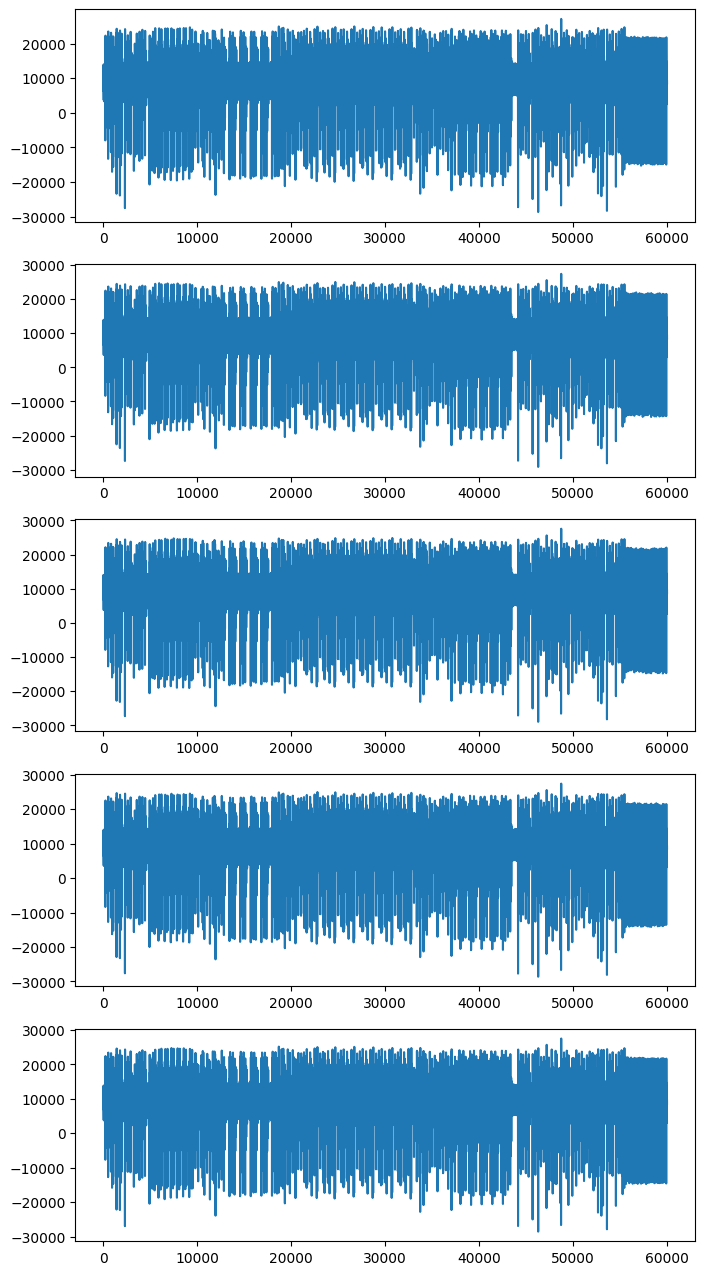

In [145]:
fig, axs = plt.subplots(NR_PLOT, figsize=(8, 16))
for ax, trace in zip(axs, traces[:NR_PLOT]):
    ax.plot(trace)
fig.show()

### Find the timepoint where S1 is executed

In [136]:
s1 = [0x09, 0x01, 0x05, 0x05, 0x00, 0x0C, 0x02, 0x06, 0x07, 0x0F, 0x0B, 0x0B, 0x10, 0x04, 0x0E, 0x0A]

def hypothesis_s1(x1: int, x2: int) -> int:
    return HW[s1[(x1 + x2) % 16]]


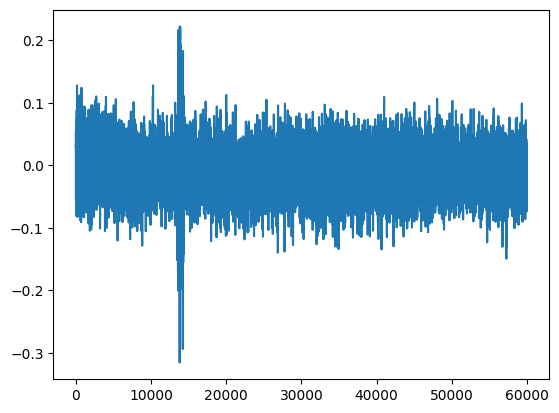

In [140]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))

Wow !!!

(13500.0, 14500.0)

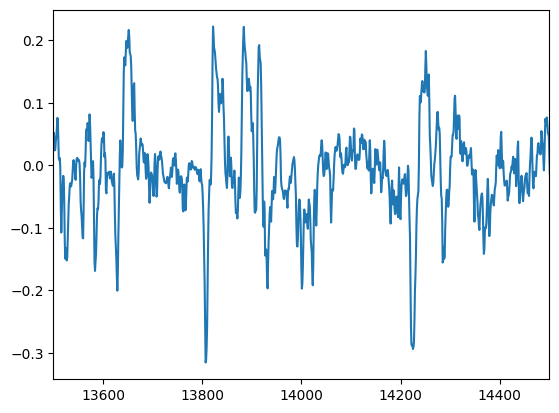

In [143]:
plt.plot(corr_coef([hypothesis_s1(int(key[1], 16), int(key[2], 16)) for key in real_keys], traces))
plt.xlim([13500, 14500])

C:\Users\ppace\AppData\Local\Temp\ipykernel_16720\1596558143.py:26: RuntimeWarning: invalid value encountered in divide
  correlation = sumnum / np.sqrt(sumden1 * sumden2)


TypeError: hypothesis_s1() takes 2 positional arguments but 500 were given

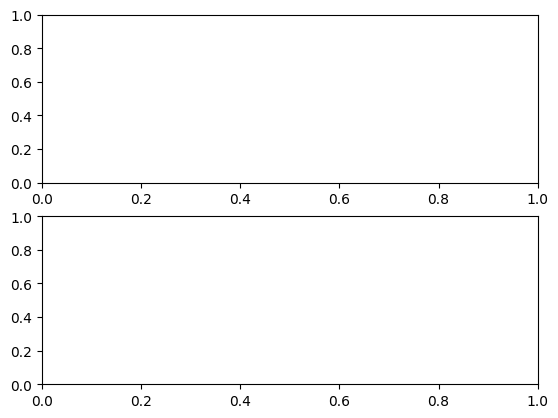

In [103]:
x_1_guess, x_2_guess = 0, 0
fig, axs = plt.subplots(2)
correlation_wrong = cpa_attack(hypothesis_s1, x_1_guess, x_2_guess)
correlation_correct = cpa_attack(hypothesis_s1, *real_key)
fig.suptitle(f'Correlation of all traces with (probably wrong) guess {x_1_guess, x_2_guess} compared to correlation with real key {real_key}')
axs[0].plot(correlation_wrong)
axs[1].plot(correlation_correct)
fig.show()

### Full attack

In [ ]:
best_guess = cpa_attack(hypothesis_s1, real_keys)

print(f"Best Key Guess: {best_guess}")

plt.plot(cpa_output[best_guess])
plt.show()